In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, linear_kernel
from sklearn.metrics.pairwise import cosine_similarity, sigmoid_kernel
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

from sklearn.base import clone

import seaborn as sns
import utils
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('final_cleaned.csv')
df.head(2)

,Unnamed: 0,name,year,run_time,genre,rating,about,director,actors,votes,gross
0,0,The Shawshank Redemption,1994,142 min,Drama,9.3,"imprisoned men bond over a number of years, fi...",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2451775,$28.34M
1,1,The Godfather,1972,175 min,"Crime, Drama",9.2,rganized crime dynasty's aging patriarch trans...,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1696937,$134.97M


In [3]:
df.columns

Index(['Unnamed: 0', 'name', 'year', 'run_time', 'genre', 'rating', 'about',
       'director', 'actors', 'votes', 'gross'],
      dtype='object')

In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.head(2)

,name,year,run_time,genre,rating,about,director,actors,votes,gross
0,The Shawshank Redemption,1994,142 min,Drama,9.3,"imprisoned men bond over a number of years, fi...",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2451775,$28.34M
1,The Godfather,1972,175 min,"Crime, Drama",9.2,rganized crime dynasty's aging patriarch trans...,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1696937,$134.97M


In [6]:
df.shape

(1218, 10)

In [7]:
df.isna().sum()

name          0
year          0
run_time      0
genre         0
rating        0
about         0
director    101
actors        0
votes         0
gross       395
dtype: int64

In [8]:
df['about'].values[:5]

array(['imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
       "rganized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.",
       ' the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.',
       'early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands and tightens his grip on the family crime syndicate.',
       'lives of two mob hitmen, a boxer, a gangster and his wife, and a pair of diner bandits intertwine in four tales of violence and redemption.'],
      dtype=object)

Text(0.5, 1.0, 'Number of Movies per Genre')

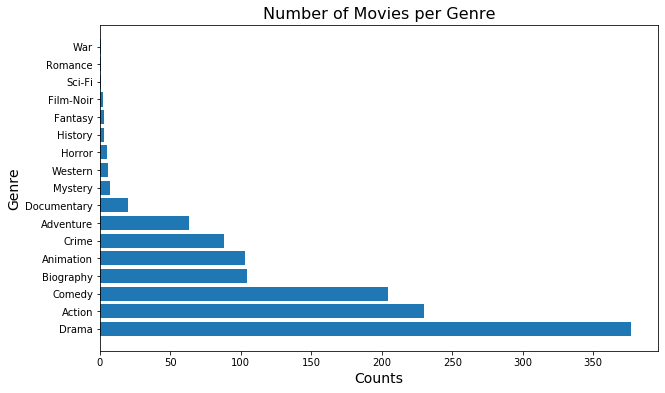

In [9]:
y = df.genre.apply(lambda x: x.split(',')[0])
genre = y.str.replace(r'\s+', '')
df_dummy = pd.DataFrame()
df_dummy['genre'] = genre
genre_df = df_dummy.genre.value_counts().reset_index()
genre_df.rename(columns={'genre': 'count', 'index': 'genre'}, inplace=True)

plt.figure(figsize=(10,6))
plt.barh(genre_df['genre'], genre_df['count'])
plt.ylabel('Genre', fontsize=14)
plt.xlabel('Counts', fontsize=14)
plt.title('Number of Movies per Genre', fontsize=16)


In [10]:
df['cleaned_overview'] = df['about'].apply(lambda x: utils.process_doc(x))
df['genre'] = df_dummy['genre'].str.lower()

In [11]:
df[['cleaned_overview', 'director', 'genre', 'actors']].head(2)

,cleaned_overview,director,genre,actors
0,imprison man bond number year find solace even...,Frank Darabont,drama,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi..."
1,rganize crime dynasty age patriarch transfer c...,Francis Ford Coppola,crime,"Marlon Brando, Al Pacino, James Caan, Diane Ke..."


In [12]:
def combined_features(row):
    return row['cleaned_overview']+" "+row['genre']

df["combined_features"] = df.apply(combined_features, axis =1)
df["combined_features"].head(2)

0    imprison man bond number year find solace even...
1    rganize crime dynasty age patriarch transfer c...
Name: combined_features, dtype: object

In [13]:
df["combined_features"].iloc[0]

'imprison man bond number year find solace eventual redemption act common decency drama'

In [14]:
# Apply the TFIDF to the data
TFIDF = TfidfVectorizer(min_df=10,lowercase=True)
tfidf = TFIDF.fit_transform(df["combined_features"])
feature_names = TFIDF.get_feature_names()
df1 = pd.DataFrame(tfidf.toarray(), columns=TFIDF.get_feature_names())
df1.head(2)

,ability,accident,accuse,across,action,adventure,affair,age,agent,ally,...,wife,woman,work,world,writer,wwii,year,yearold,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.506212,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46242,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


# Selecting the Number of Topics

To identify the rank, or number of components to use ideally, we want the smallest rank that minimizes the error. However, this rank may be too computationally expensive, as in this situation. We'll choose the rank by using the following method. First, calculate the frobenius norm of the dataframe and multiply it by .0001. This will be our benchmark value. Next, iterate through
rank = 3, 4, 5, .... For each iteration, run NMF using n_components=rank and reconstruct the matrix A. Calculate the root mean square error of the original dataframe and the reconstructed matrix A_k. When the RMSE is less than the benchmark value, we will stop and use the rank and the reconstructed matrix.

## Reconstruction root mean squared error

In [15]:
np.arange(1, 320, 5)

array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126,
       131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191,
       196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256,
       261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316])

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
rmse_all = []
num_topics = df1.shape[1]
for k in range(1,num_topics, 5):
    A = df1.copy()
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(A)
    H = model.components_
    # get the reconstructed A with dimensions k
    A_k = W.dot(H)
    rmse_frob = mean_squared_error(A, A_k, squared=False)
    # getting reconstruction error (RMSE)
    rmse_all.append(rmse_frob)


In [18]:
#setting the threshold 
frob_norm_A = np.linalg.norm(A, 'fro')
threshold = frob_norm_A*0.001
print(threshold)

0.034899856733230296


In [19]:
rmse_bool = rmse_all < threshold
rmse_bool

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [20]:
from scipy import interpolate
x = np.arange(1, num_topics, 5)
rmse = rmse_all

#interpolate missing values or "gaps"
xnew = np.arange(1, num_topics)
f = interpolate.interp1d(x, rmse, fill_value="extrapolate")
rmse_new = f(xnew)

len(rmse_new)

319

In [21]:
rmse_bool = rmse_new < threshold

In [22]:
best_k = np.where(rmse_bool == True)[0][0] + 1

Min rec_err: 0.0021313838919372603 at k: 89 



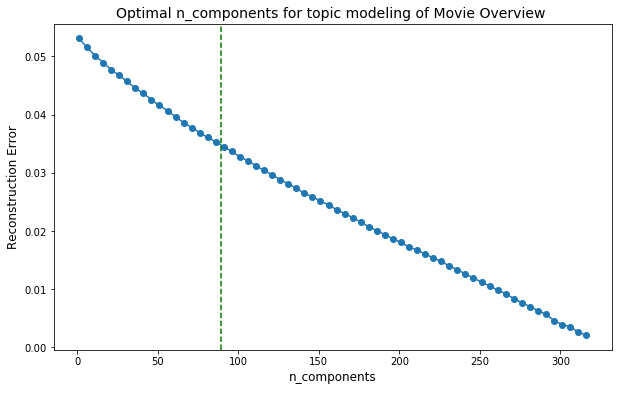

In [23]:
# Plot the interpolated reconstruction error curve 
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,num_topics,5), rmse_all, 'o-')

plt.axvline(best_k, ls='--', color='g')
plt.title('Optimal n_components for topic modeling of Movie '
          'Overview ', fontsize=14)
plt.ylabel('Reconstruction Error', fontsize=12)
plt.xlabel('n_components\n', fontsize=12)
print(f"Min rec_err: {min(rmse_all)} at k: {(best_k)}", "\n")
plt.show()

## Simple Movie Recommender System vs Random Recommender

Recommendation Systems work based on the similarity between either the content or the users who access the content.
There are several ways to measure the similarity between two items. The recommendation systems use this similarity matrix to recommend the next most similar product to the user.

In this lab, we will build a machine learning algorithm that would recommend movies based on a movie overview and genre. We will use NMF to find two non-negative matrices (W, H) whose product approximates the non- negative matrix A. We will reconstruct the matrix using their dot product. This reconstructed matrix serves as a basis to the recommendation. We will the compute the Cosine Similarity from Sklearn, as the metric to compute the pairwise similarity scores between 2 movies.

In [25]:
n_topics = 89
nmf_ = NMF(n_components=n_topics, max_iter=100).fit(tfidf)
nmf  = nmf_.transform(tfidf)

The python Cosine Similarity or cosine kernel, computes similarity as the normalized dot product of input samples X and Y. We will use the sklearn cosine_similarity to find the cos θ for the two vectors in the count matrix.
The `cosine_sim` matrix is a numpy array with calculated cosine similarity between each movies. 

In [33]:
def get_top_recommended_movies(df, title, k, cosine_sim):
    """Return the top k movie if found in the database, else 
    tell user to input another movie.
    """
    title = title.lower()
    if title in df.name.str.lower().unique():
        
        index = df[df.name.str.lower() == title].index[0]
        similar_movies_cos = list(enumerate(cosine_sim[index]))
        sorted_similar_movies_cos = sorted(similar_movies_cos,
                                       key=lambda x:x[1],
                                       reverse=True)[1:k+1]
        
        for movie_id, score in sorted_similar_movies_cos:
            print(df.iloc[movie_id]['name'])
    else:
        return "Movie not found in the database."

In [41]:
def get_random_model_movies(df, title, k, random_state=10):
    """Return  of the movie if found in the database, else 
    tell user to input another movie.
    """
    title = title.lower()
    if title in df.name.str.lower().unique():
        
        index = df[df.name.str.lower() == title].index[0]
        np.random.seed(random_state)
        choices = np.random.choice(df.name, size=k)
        
        for movie in choices:
            print(movie)
    else:
        return "Movie not found in the database."

Cosine similarity is a metric used to measure how similar two items are. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The output value ranges from 0–1.
0 means no similarity, where as 1 means that both the items are 100% similar.

In [42]:
cosine_sim = cosine_similarity(tfidf)

In [43]:
movie_user_likes = "The Godfather"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5)

Model Recommendations:
Double Indemnity
The Big Heat
Tengoku to jigoku
Du rififi chez les hommes
Fargo


Random Recommendations:
Flipped
The Spy Who Loved Me
My Life in Ruins
Step Up 2: The Streets
MythBusters


In [44]:
movie_user_likes = "Casino Royale"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 12)

Model Recommendations:
 Climax!
Lady Bird
I Am a Fugitive from a Chain Gang
Hachi: A Dog's Tale
The Internet's Own Boy: The Story of Aaron Swartz


Random Recommendations:
We Own the Night
Whitney
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb
Erufen rîto
Vozvrashchenie


In [46]:
movie_user_likes = "X-men"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 22)

Model Recommendations:
Flammen & Citronen
Wolf's Rain
Om det oändliga
The Perks of Being a Wallflower
Fight Club


Random Recommendations:
Alatriste
Amadeus
Habermann
The Lunchbox
Trilogia II: I skoni tou hronou


In [47]:
movie_user_likes = "Skyfall"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 30)

Model Recommendations:
I Am a Fugitive from a Chain Gang
Ben-Hur
Lady Bird
Revolutionary Road
The Mountain Between Us


Random Recommendations:
Sorry We Missed You
Tmavomodrý svet
Spawn
The Shadow Dancer
Voces inocentes


In [48]:
movie_user_likes = "The Dark Knight"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 32)

Model Recommendations:
Alexander
Ant-Man
La battaglia di Algeri
A Brief History of Time
Michael Clayton


Random Recommendations:
The Blue Planet
Le puits
The Shining
The Matrix Reloaded
Just Go with It


In [50]:
movie_user_likes = "The Shawshank Redemption"

print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 90)

Model Recommendations:
Bom yeoreum gaeul gyeoul geurigo bom
Oldeuboi
For Your Eyes Only
Me Before You
Cool Hand Luke


Random Recommendations:
Un condamné à mort s'est échappé ou Le vent souffle où il veut
To Have and Have Not
Le fantôme de la liberté
Dragon Ball
White Heat


In [52]:
movie_user_likes = "Sailor Moon"

print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes,5, 22)

Model Recommendations:
Dragon Ball Z
Guardians of the Galaxy
Teenage Mutant Ninja Turtles
Dragon Ball Z: Doragon bôru zetto
Fantastic Four


Random Recommendations:
Alatriste
Amadeus
Habermann
The Lunchbox
Trilogia II: I skoni tou hronou


In [53]:
movie_user_likes = "Ponyo"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 22)

Model Recommendations:


Random Recommendations:


'Movie not found in the database.'

In [54]:
movie_user_likes = "3 Idiots"

print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 1)

Model Recommendations:
50 First Dates
Harvey
Vicky Cristina Barcelona
The Hangover
Hors de prix


Random Recommendations:
Memoirs of a Geisha
Butch Cassidy and the Sundance Kid
How to Lose a Guy in 10 Days
The Yellow Birds
Die Büchse der Pandora


In [55]:
movie_user_likes = "Finding Nemo"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 18)

Model Recommendations:
Te doy mis ojos
Fish Tank
Hachi: A Dog's Tale
Akame ga Kill!
Ladri di biciclette


Random Recommendations:
Sicario: Day of the Soldado
40 Days and 40 Nights
Kingdom of Heaven
Jeune et jolie
In the Name of the Father


In [56]:
movie_user_likes = "Jurassic Park"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 2)

Model Recommendations:
El Camino: A Breaking Bad Movie
Dracula Untold
Tôkyô monogatari
Psycho
Closer


Random Recommendations:
The Family Man
The Spy Who Loved Me
Batman: The Animated Series
Vice
Psycho-Pass


In [58]:
movie_user_likes = "Gone Girl"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5,3)

Model Recommendations:
The Family Man
The Ox-Bow Incident
Paper Moon
The Heiress
The Red Shoes


Random Recommendations:
Die Flucht
Avatar
Doctor Strange
The Monuments Men
Hannibal Rising


In [59]:
movie_user_likes = "Rurôni Kenshin - Meiji kenkaku romantan"

print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 4)

Model Recommendations:
Ôran kôkô hosutobu
Rurouni Kenshin: Meiji Kenkaku Romantan: Tsuioku Hen
The Real Ghost Busters
Step Up
Step Up 2: The Streets


Random Recommendations:
The Lake House
Inside Out
Steins;Gate
Fail Safe
Arrival


In [60]:
movie_user_likes = "Spider-Man"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 5)

Model Recommendations:
Midnight Cowboy
Uncut Gems
Taxi Driver
The Godfather: Part II
Toxic Crusaders


Random Recommendations:
Fetih 1453
Prisoners
Jiro Dreams of Sushi
The Holiday
X-Men


In [61]:
movie_user_likes = "The Blue Planet"
print('Model Recommendations:')
get_top_recommended_movies(df, movie_user_likes, 5, cosine_sim)

print('\n')
print('Random Recommendations:')
get_random_model_movies(df, movie_user_likes, 5, 7)

Model Recommendations:
Whitney
Planet Earth
The Jinx: The Life and Deaths of Robert Durst
Frozen Planet
The World at War


Random Recommendations:
A Beautiful Mind
The World Is Not Enough
God, the Devil and Bob
Stand by Me
Voces inocentes


# Clustering

If  a  document  is viewed as a combination of basis vectors, then it can be categorized as belonging to the topic represented by its principal  vector.  Thus, NMF  can  be  used  to  organize text  collections  into  partitioned  structures  or  clusters directly derived from the nonnegative factors.

Use unsupervised learning to understand what type of natural clusters exist within the movies.
Since the number of features in the dataset are very high, we will perform dimensionality reduction to reduce it to a suitable number so as to avoid the curse of dimensionality.

In [62]:
tfidf.shape

(1218, 320)

In [66]:
nmf1 = NMF(n_components=2, max_iter=100)

Text(0, 0.5, 'SV2')

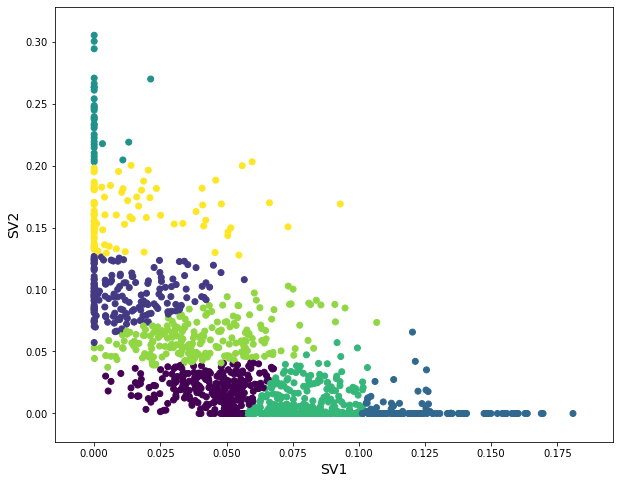

In [69]:
# lsa = TruncatedSVD(n_components=2, random_state=1337)
X_new = nmf1.fit_transform(df1.to_numpy())
kmeans_ng = KMeans(n_clusters=7, random_state=1337)
y_predict= kmeans_ng.fit_predict(X_new)
plt.figure(figsize=(10,8))
plt.scatter(X_new[:,0], X_new[:,1], c=y_predict)
plt.xlabel('SV1',fontsize=14)
plt.ylabel('SV2', fontsize=14)
# plt.savefig('Kmeans_cluster', dpi=300)

In [72]:
def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    ys = []
    centers = []
    inertias = []
    chs = []
    scs = []
   
    for k in range(k_start, k_stop+1):
        clusterer_k = clone(clusterer)
        clusterer_k.set_params(n_clusters=k)
        clusterer_k.fit(X)
        y = clusterer_k.predict(X)
        ys.append(y)
        centers.append(clusterer_k.cluster_centers_)
        inertias.append(clusterer_k.inertia_)
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
       
    cluster_dict = {'ys': ys,
                    'centers': centers,
                    'inertias': inertias,
                    'chs': chs,
                    'scs': scs
                   }

    return cluster_dict

In [80]:
cluster_dict = cluster_range(df1.to_numpy(),
                             KMeans(random_state=1337),
                             2, 30, actual=None)

In [107]:
def plot_internal( chs, scs):
    """Plot internal validation values"""
    fig, ax = plt.subplots(figsize=(10,6))
    ks = np.arange(2, len(chs)+2)
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Calinski Harabasz score')
    ax.yaxis.set_label_position("left")
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Silhouette score')
    ax2.yaxis.set_label_position("right")
    
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines+lines2, labels+labels2, bbox_to_anchor=(1.1,1))
    return ax

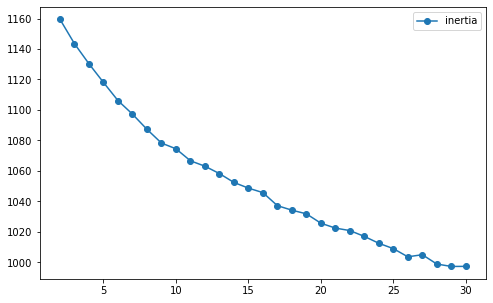

In [108]:
plt.subplots(figsize=(8,5))
plt.plot(np.arange(2,len(cluster_dict['inertias'])+2),
         cluster_dict['inertias'], 'o-', label='inertia',)
plt.legend();

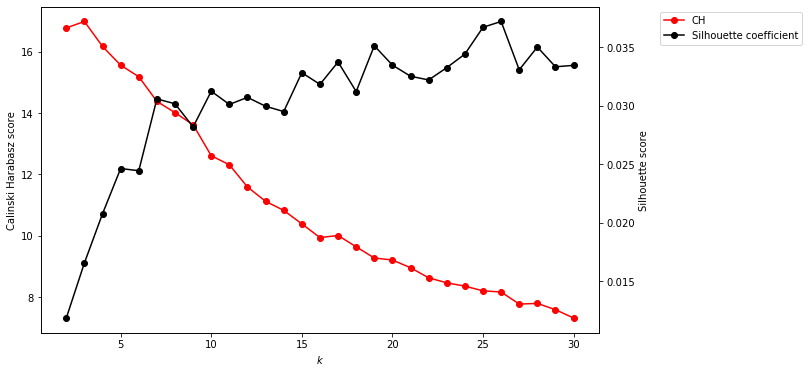

In [109]:
plot_internal(cluster_dict['chs'],
               cluster_dict['scs'])


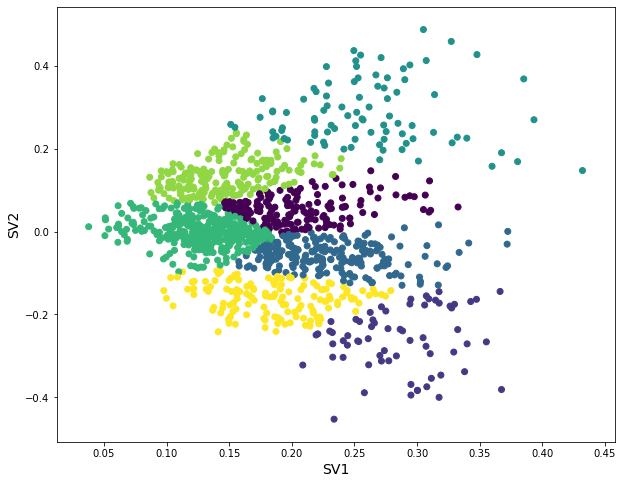

In [110]:
lsa = TruncatedSVD(n_components=2, random_state=1337)
X_new = lsa.fit_transform(df1.to_numpy())
kmeans_ng = KMeans(n_clusters=7, random_state=1337)
y_predict= kmeans_ng.fit_predict(X_new)
plt.figure(figsize=(10,8))
plt.scatter(X_new[:,0], X_new[:,1], c=y_predict)
plt.xlabel('SV1',fontsize=14)
plt.ylabel('SV2', fontsize=14)
plt.savefig('Kmeans_cluster', dpi=300)

In [111]:
df['cluster_label'] = y_predict

In [112]:
wiki = df[['name', 'cluster_label', 'votes']].sort_values(by='cluster_label')

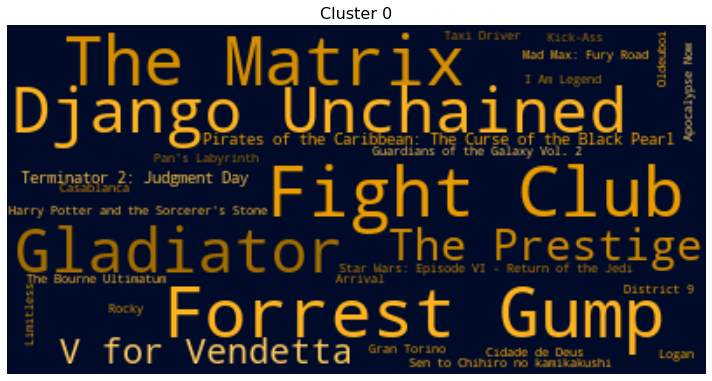

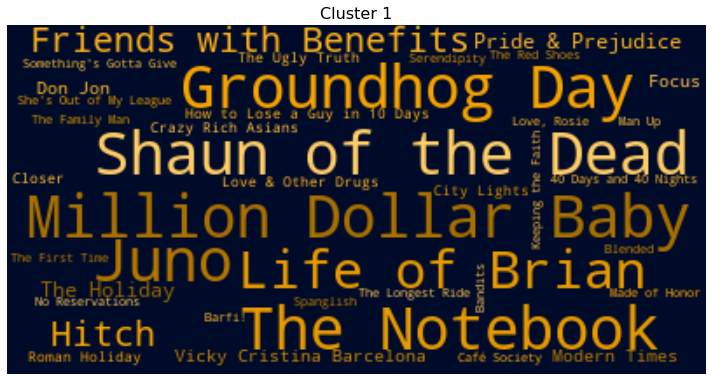

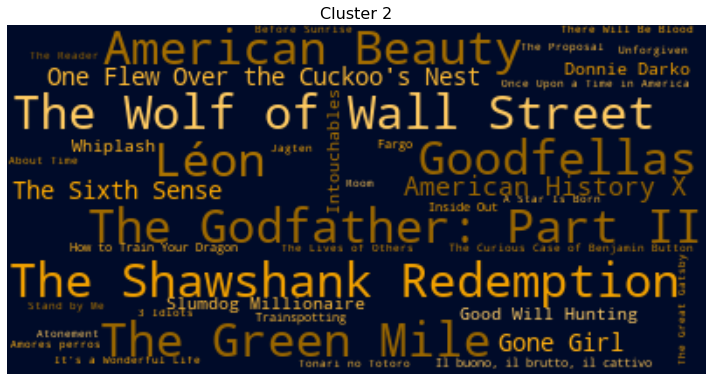

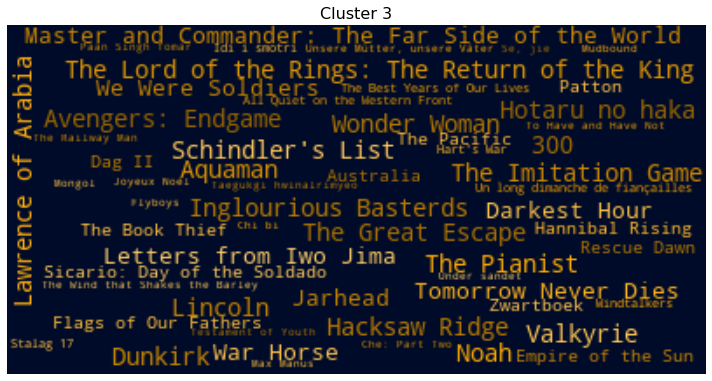

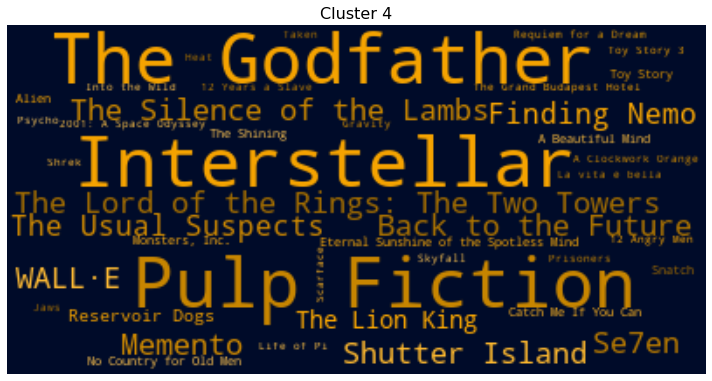

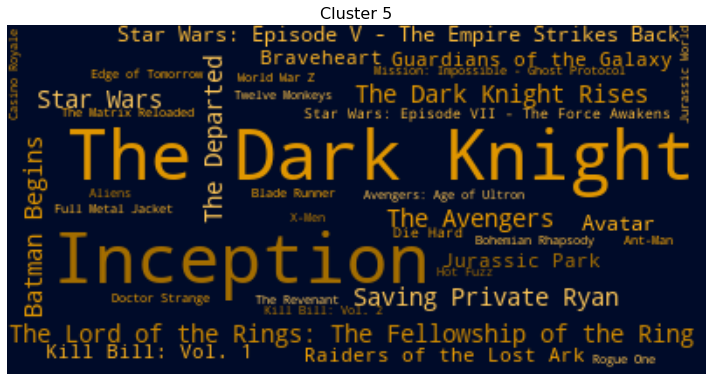

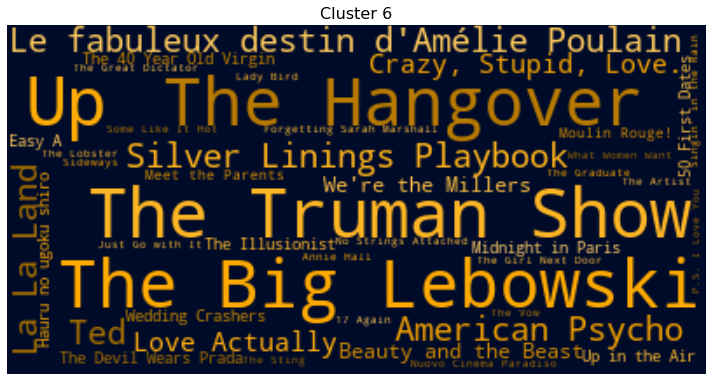

In [120]:
from PIL import Image, ImageFont
from wordcloud import WordCloud
mask2 = np.array(Image.open("face.png"))
# font_path = 'Charming-Regular.otf'
def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h = 40 # 0 - 360c
    s = 100 # 0 - 100
    l = random_state.randint(30, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)


for k in range(0,7):
    
    df = wiki[wiki['cluster_label']==k].sort_values('votes',
                                          ascending=False)[:150]

    titles=df['name'].values
    d = dict(zip(titles, [1]*len(titles)))
    
    wordcloud = WordCloud(max_font_size=40, max_words=100, min_font_size=6,
                          background_color="#000B29", 
                        color_func=similar_color_func, mask=mask2
                       ).generate_from_frequencies(d)
    #show
    plt.figure(figsize=(10,10))
    plt.title('Cluster '+str(k), fontsize=16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
    plt.tight_layout()
    name_fig = 'cluster'+str(k)+'.png'
    plt.savefig(name_fig, dpi=300)


## 

# Calculating Model Performance

In [122]:
df_orig = pd.read_csv('final_cleaned.csv')

In [123]:
df_orig['label'] = y_predict

In [427]:
df_orig.head(2)

,Unnamed: 0,name,year,run_time,genre,rating,about,director,actors,votes,gross,label
0,0,The Shawshank Redemption,1994,142 min,Drama,9.3,"imprisoned men bond over a number of years, fi...",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2451775,$28.34M,2
1,1,The Godfather,1972,175 min,"Crime, Drama",9.2,rganized crime dynasty's aging patriarch trans...,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1696937,$134.97M,4


In [391]:
def get_index_of_top_recommended_movies(df, title, k, cosine_sim):
    """Return the labels of recommended movie if found in the database."""
    
    title = title.lower()
    if title in df.name.str.lower().unique():
        
        index = df[df.name.str.lower() == title].index[0]
        similar_movies_cos = list(enumerate(cosine_sim[index]))
        sorted_similar_movies_cos = sorted(similar_movies_cos,
                                       key=lambda x:x[1],
                                       reverse=True)[1:k+1]
        movies_label = []
        for movie_idx, score in sorted_similar_movies_cos:
            movies_label.append(movie_idx)
          
        return movies_label

    
def get_index_of_random_movies(df, title, k, random_state=10):
    """Return  of the movie if found in the database, else 
    tell user to input another movie.
    """
    title = title.lower()
    movies_label = []
    if title in df.name.str.lower().unique():
        
        index = df[df.name.str.lower() == title].index[0]
        np.random.seed(random_state)
        choices = np.random.choice(df.name, size=k)
        
        for movie in choices:
            random_label = df[df.name==movie].index[0]
            movies_label.append(random_label)
        return movies_label


In [393]:
# # for title in all_titles[:5]:
# title='The Godfather'
# top_5_label =[]
# movie_label = df_orig[df_orig['name'] == title]['label'].values[0]
# movies_recom_index = get_labels_of_top_recommended_movies(df_orig, title, 
#                                     5, cosine_sim)

# movies_random_index = get_labels_of_random_movies(df_orig, title,
#                                           5, random_state=20)

In [402]:
def get_confusion(actual, results, all_labels):
    """Return the confusion matrix as a pandas DataFrame
    
    Accept the label of the correct class,
    the returned results as indices to the
    objects and all labels, and return the
    confusion matrix as a pandas DataFrame
    """
    df = pd.DataFrame(all_labels)
    ret_df = df[df.index.isin(results)]    #relevant
    not_df = df[~df.index.isin(results)]   #not relevant

    TP = sum(ret_df[0]==actual)
    FP = len(ret_df) - TP
    FN = sum(not_df[0]==actual)
    TN = len(not_df) - FN


    return pd.DataFrame([[TP, FP], [FN, TN]],
                        columns=['relevant', 'irrelevant'],
                        index=['relevant', 'irrelevant'])

def precision(confusion):
    """Accept a confusion matrix and returns the precision"""

    tp = confusion.relevant[0]
    fp = confusion.irrelevant[0]
    if tp + fp == 0:
        return 1
    return tp/(tp+fp)


def recall(confusion):
    """Accept a confusion matrix and returns the recall"""
    tp = confusion.relevant[0]
    fn = confusion.relevant[1]
    return tp/(tp+fn)


In [403]:
def summary_of_performance(actual, all_predicted_label_index, y_predict):
    """Return the precision and recall of the query."""
    
    confusion_movie = get_confusion(actual, all_predicted_label_index,
                                    y_predict)
    precision_score = precision(confusion_movie)
    recall_score = recall(confusion_movie)
    
    return precision_score, recall_score

In [422]:
def compute_model_performance(df_orig, k, cosine_sim):
    """Return the precision of all of the queries for the random model
    and the recommender model."""
    
    all_titles = df_orig.name.values
    y_predict = df_orig.label.values

    #store models precision scores
    model_precision_scores_all = []
    random_precision_scores_all = []


    for seed, title in enumerate(all_titles):

        movie_label = df_orig[df_orig['name'] == title]['label'].values[0]
        movies_recom_index = get_index_of_top_recommended_movies(df_orig,
                                        title, k, cosine_sim)
        movies_random_index = get_index_of_random_movies(df_orig, title,
                                        k, random_state=seed)

        model_prec, model_rec = summary_of_performance(movie_label,
                                             movies_recom_index, y_predict)

        random_prec, random_rec = summary_of_performance(movie_label,
                                            movies_random_index, y_predict)

        model_precision_scores_all.append(model_prec)
        random_precision_scores_all.append(random_prec)
    return model_precision_scores_all, random_precision_scores_all

In [423]:
model_mean_precision, random_mean_precision = compute_model_performance(
                                            df_orig, 10, cosine_sim)
random_precision_mean_k10 = np.mean(random_mean_precision)
model_precision_mean_k10 = np.mean(model_mean_precision)


In [424]:
model_mean_precision, random_mean_precision = compute_model_performance(
                                            df_orig, 5, cosine_sim)
random_precision_mean_k5 = np.mean(random_mean_precision)
model_precision_mean_k5 = np.mean(model_mean_precision)


In [425]:
print(random_precision_mean_k10)
print(model_precision_mean_k10)

0.1776249771939427
0.35985221674876844


In [426]:
print(random_precision_mean_k5)
print(model_precision_mean_k5)

0.1720032840722496
0.3715927750410509
